In [1]:
import sys; sys.path.append('/home/cb2714/wwa'); from wwa import *

In [25]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

# Create low-resolution datasets

In [30]:
era5 = decode_times(xr.open_dataset("era5_t2m_daily_1_max_30.nc", decode_times = False)).max_t2m.sel(time = slice(None, "2023")) - 273.15
era5_lsm = xr.open_dataset("era5_000000_lsm_05.nc").lsm.squeeze(drop = True)

# filter land cells only
era5 = era5.where(era5_lsm >= 0.5)
era5 = era5.assign_coords(time = era5.time.dt.year).rename(time = "year")

# aggregate over 8x8 blocks
era5_lr = era5.coarsen(lon = 8).mean().coarsen(lat = 8).mean().sel(lat = slice(None, -65))

# create a revised land-sea mask
bmask = xr.ones_like(era5_lsm).where(era5_lsm >= 0.5, 0).coarsen(lon = 8).mean().coarsen(lat = 8).mean().sel(lat = slice(None, -65))
era5_lr = era5_lr.where(bmask >= 0.5)

era5_lr.to_netcdf("era5_maxt2m_lowres.nc")

# create a .csv containing only land cells, for model fitting in R (flatten & clean up one cell where model failed to converge)
era5_lr.stack(xy = ["lon", "lat"]).dropna("xy", "all")

era5_cells = era5_lr.stack(xy = ["lon", "lat"]).dropna("xy", "all")
era5_cells.to_pandas().to_csv("era5_maxt2m_land.csv")

# Switch to R to perform model fitting

# Maps of fitted models

### Effect on $\alpha$ of shift vs shift+scale
- very little effect on the linear trend when the variance is allowed to vary vs kept fixed

In [110]:
y1 = "1950"

df_shift = pd.read_csv("fitted_"+y1+"-2023_shift_model-pars.csv", index_col = 0)
pars_shift = xr.merge([vec2map(df_shift.loc[r], era5_lr.isel(year = -1, drop = True)).rename(r) for r in df_shift.index])

df_shiftscale = pd.read_csv("fitted_"+y1+"-2023_shiftscale_model-pars.csv", index_col = 0)
pars_shiftscale = xr.merge([vec2map(df_shiftscale.loc[r], era5_lr.isel(year = -1, drop = True)).rename(r) for r in df_shiftscale.index])

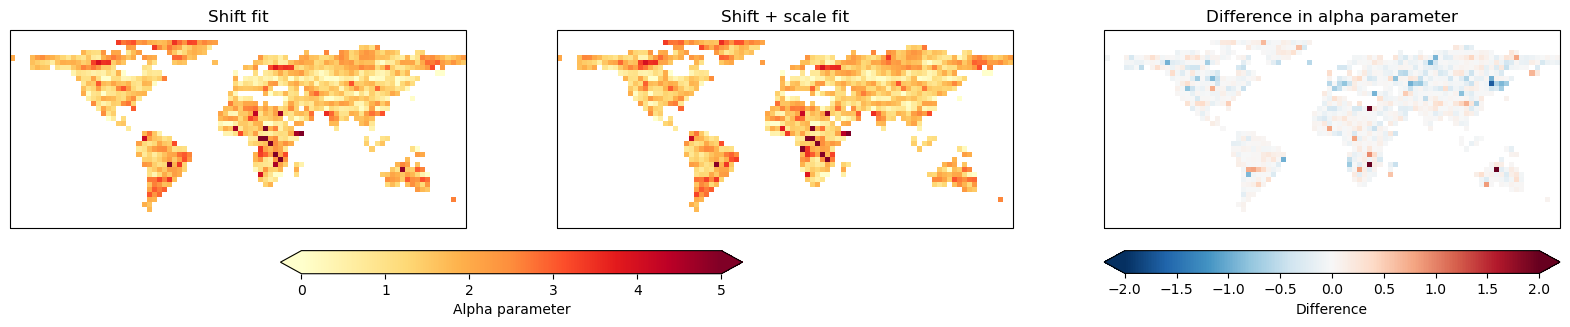

In [111]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plot_kwargs = {"vmin" : 0, "vmax" : 5, "cmap" : "YlOrRd", "add_colorbar" : False}

cbar = pars_shift.alpha.plot(ax = axs[0], **plot_kwargs)
axs[0].set_title("Shift fit")
pars_shiftscale.alpha.plot(ax = axs[1], **plot_kwargs)
axs[1].set_title("Shift + scale fit")

plt.colorbar(cbar, ax = axs[:2], location = "bottom", fraction = 0.05, pad = 0.05, label = "Alpha parameter", extend = "both")

cbar = (pars_shift - pars_shiftscale).alpha.plot(ax = axs[2], add_colorbar = False, vmin = -2, vmax = 2, cmap = "RdBu_r")
axs[2].set_title("Difference in alpha parameter")

plt.colorbar(cbar, ax = axs[2:], location = "bottom", fraction = 0.05, pad = 0.05, label = "Difference", extend = "both")

### Estimated $\beta$ in shift+scale

- mix of increasing and decreasing trend in variance - no evidence of an overall tendency toward increasing variance
- the trend is stronger when we look at shorter timescales (perhaps unexpectedly?)
- also areas with stronger (weaker) variance tend to have lower (higher) estimates of sigma_0

In [105]:
y1 = "1950"

df_1950 = pd.read_csv("fitted_1950-2023_shiftscale_model-pars.csv", index_col = 0)
pars_1950 = xr.merge([vec2map(df_1950.loc[r], era5_lr.isel(year = -1, drop = True)).rename(r) for r in df_1950.index])

df_1979 = pd.read_csv("fitted_1979-2023_shiftscale_model-pars.csv", index_col = 0)
pars_1979 = xr.merge([vec2map(df_1979.loc[r], era5_lr.isel(year = -1, drop = True)).rename(r) for r in df_1979.index])

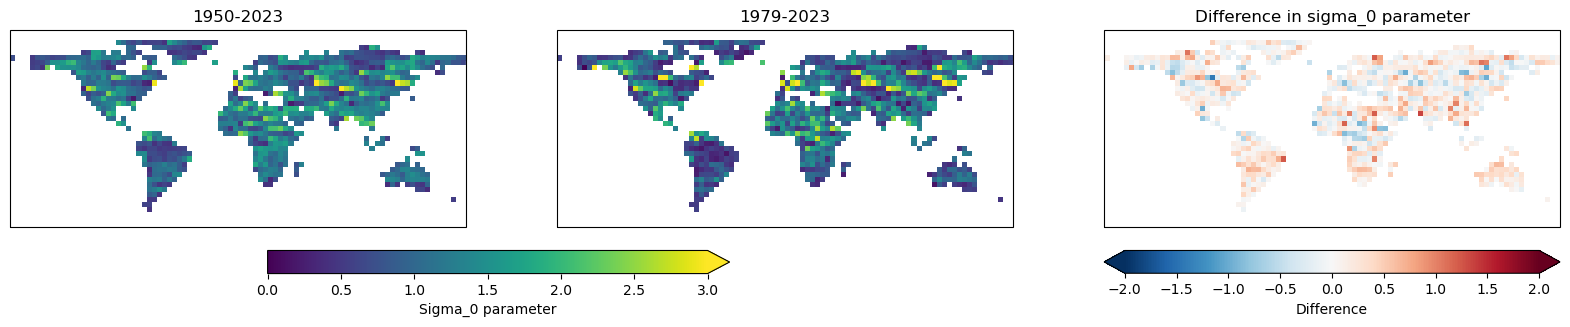

In [115]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plot_kwargs = {"vmin" : 0, "vmax" : 3, "cmap" : "viridis", "add_colorbar" : False}
# plot_kwargs = {"add_colorbar" : True}
cbar = pars_1950.sigma0.plot(ax = axs[0], **plot_kwargs)

axs[0].set_title("1950-2023")
pars_1979.sigma0.plot(ax = axs[1], **plot_kwargs)
axs[1].set_title("1979-2023")

plt.colorbar(cbar, ax = axs[:2], location = "bottom", fraction = 0.05, pad = 0.05, label = "Sigma_0 parameter", extend = "max")

cbar = (pars_1950 - pars_1979).sigma0.plot(ax = axs[2], add_colorbar = False, vmin = -2, vmax = 2, cmap = "RdBu_r")
axs[2].set_title("Difference in sigma_0 parameter")

plt.colorbar(cbar, ax = axs[2:], location = "bottom", fraction = 0.05, pad = 0.05, label = "Difference", extend = "both")

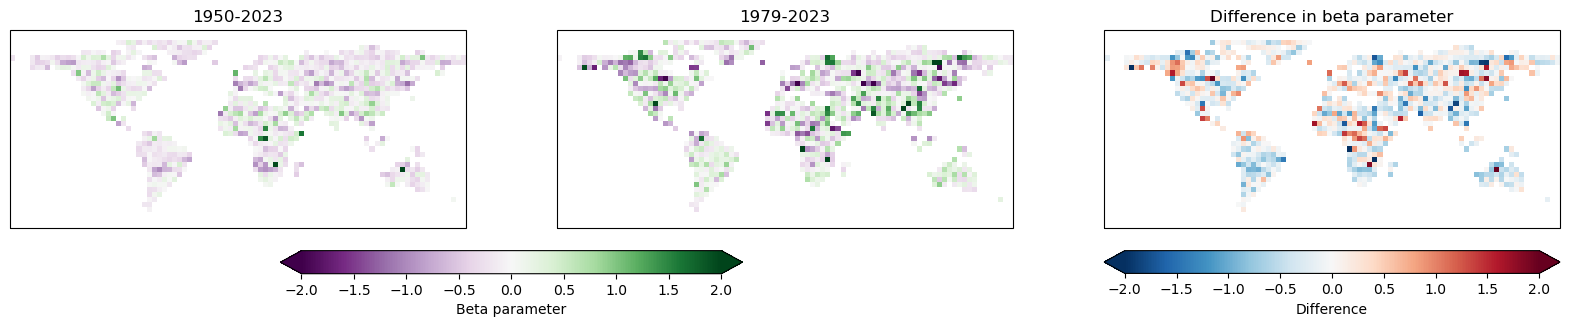

In [109]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plot_kwargs = {"vmin" : -2, "vmax" : 2, "cmap" : "PRGn", "add_colorbar" : False}
# plot_kwargs = {"add_colorbar" : True}
cbar = pars_1950.beta.plot(ax = axs[0], **plot_kwargs)

axs[0].set_title("1950-2023")
pars_1979.beta.plot(ax = axs[1], **plot_kwargs)
axs[1].set_title("1979-2023")

plt.colorbar(cbar, ax = axs[:2], location = "bottom", fraction = 0.05, pad = 0.05, label = "Beta parameter", extend = "both")

cbar = (pars_1950 - pars_1979).beta.plot(ax = axs[2], add_colorbar = False, vmin = -2, vmax = 2, cmap = "RdBu_r")
axs[2].set_title("Difference in beta parameter")

plt.colorbar(cbar, ax = axs[2:], location = "bottom", fraction = 0.05, pad = 0.05, label = "Difference", extend = "both")